**Content Disclaimer**: This dataset contains real title posts scraped from the r/depression subreddit, and some of the titles contain language that is not safe for work, crude, or offensive. The full dataset is available as `depression.csv`, `preprocessed_thoughts.csv`, `thoughts.csv`, and `token_df.csv`. Unfortunately, I did not provide a sanitized version of my dataset because the words contained were important for the analysis and understanding of the model. Please note that the model, the dataset, and the techniques used are not perfect. If you have any concerns about working with this dataset, looking at my analysis, or the topic in general, you can skip my content overall or click [here](http://iamsorry.com/).

# EDA

A reminder that our EDA will be based on the subreddits `r/depression` and `r/Showerthoughts`.

---
## Imports

In [3]:
import p3_tools as p3t

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV # preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # for plotting
from sklearn.naive_bayes import MultinomialNB # Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # transforming

# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# from nltk.stem import WordNetLemmatizer
# from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [4]:
# import the notebook
thoughts = pd.read_csv('saved_data/preprocessed_thoughts.csv')

In [5]:
thoughts.sample(5)

,subreddit,title,word_count,char_count
11427,1,"If i had the energy to improve my life, I'd al...",18,84
5847,0,All these masks are the closest society will e...,17,92
7714,0,Communism is mandatory sharing.,4,31
13806,1,If I died tomorrow..,4,20
13642,1,I just want to be a wife and mom... we were go...,25,112


In [6]:
depression = thoughts[thoughts['subreddit']==1]
shower = thoughts[thoughts['subreddit']==0]

In [7]:
depression.head()

,subreddit,title,word_count,char_count
10000,1,Finally catching my breath.,4,27
10001,1,"""Friends""",1,9
10002,1,"Yes, im a failure of a child but at least if y...",25,110
10003,1,Being Young With BiPolar,4,24
10004,1,Love is the only cure for my depression,8,39


In [8]:
shower.head()

,subreddit,title,word_count,char_count
0,0,Vampires and skeletons are just different type...,9,59
1,0,Life is actually a telltale game because the c...,13,66
2,0,Wouldn’t a botched circumcision just be a peni...,8,53
3,0,You might of made a decision that saved your l...,13,70
4,0,"If you have ever opened the toilet water tank,...",24,116


# Summary Statistics

In [9]:
thoughts.describe(include='all')

,subreddit,title,word_count,char_count
count,20000.000000,20000,20000.000000,20000.000000
unique,NaN,19557,NaN,NaN
top,NaN,Help,NaN,NaN
freq,NaN,16,NaN,NaN
mean,0.500000,NaN,11.857650,64.066200
std,0.500013,NaN,8.535522,46.577097
min,0.000000,NaN,1.000000,1.000000
25%,0.000000,NaN,6.000000,30.000000
50%,0.500000,NaN,10.000000,54.000000
75%,1.000000,NaN,16.000000,86.000000


In [10]:
depression.describe(include='all')

,subreddit,title,word_count,char_count
count,10000.0,10000,10000.000000,10000.000000
unique,NaN,9593,NaN,NaN
top,NaN,Help,NaN,NaN
freq,NaN,16,NaN,NaN
mean,1.0,NaN,8.204200,42.687300
std,0.0,NaN,6.674411,34.861705
min,1.0,NaN,1.000000,1.000000
25%,1.0,NaN,4.000000,21.000000
50%,1.0,NaN,6.000000,33.000000
75%,1.0,NaN,10.000000,54.000000


In [11]:
shower.describe(include='all')

,subreddit,title,word_count,char_count
count,10000.0,10000,10000.0000,10000.000000
unique,NaN,9979,NaN,NaN
top,NaN,You're literally gay in fistfight terms if you...,NaN,NaN
freq,NaN,2,NaN,NaN
mean,0.0,NaN,15.5111,85.445100
std,0.0,NaN,8.6297,47.005578
min,0.0,NaN,1.0000,1.000000
25%,0.0,NaN,10.0000,53.000000
50%,0.0,NaN,14.0000,77.000000
75%,0.0,NaN,20.0000,108.000000


# Deleted Post Check
I will check for any possible deleted, removed, or empty titled posts.

In [12]:
thoughts[thoughts['title']=='[deleted]']

,subreddit,title,word_count,char_count


In [13]:
thoughts[thoughts['title']=='[removed]']

,subreddit,title,word_count,char_count
5898,0,[removed],1,9


In [14]:
thoughts[thoughts['title']=='']

,subreddit,title,word_count,char_count


Since there is only one removed post, I will remove it from the dataframe.

In [15]:
thoughts = thoughts[thoughts['title'] != '[removed]']

In [16]:
thoughts.shape

(19999, 4)

# Duplicate Check?

Before we drop any duplicates, we will check to see if there are any. I want to gauge how much a strength a word or title contains in both the `r/depression` and `r/Showerthoughts` subreddits.

In [17]:
shower_title = pd.DataFrame(shower['title'].value_counts())
depression_title = pd.DataFrame(depression['title'].value_counts())

In [18]:
shower_title[shower_title['title']>1]

,title
You're literally gay in fistfight terms if you only accept fights with the same gender,2
"Since life is made of atoms, there is a chance you may reincarnated after you death.",2
"If the ocean was crystal clear, people with the fear of heights would never board a ship",2
H,2
"If you take literally any one letter out of ""Meow,"" it makes a more realistic cat than ""Meow"" does.",2
The brain named itself.,2
"It's not illegal to park there, it just costs a couple hundred dollars",2
That one guy from Superman was way too enthusiastic about seeing a bird.,2
"Everyone thinks moms want to go out to eat so they don’t have to cook, but actually they just want to eat a meal uninterrupted.",2
"None of the unborn wish to be born, but plenty of the living wish they had never been born",2


In [19]:
depression_title[depression_title['title']>1].head(10)

,title
Help,16
.,13
Alone,10
Tired,8
I don’t know what to do,7
I’m so tired,7
Depression,7
Struggling,7
Lost,6
I need help,6


There are a lot more duplicates at a much higher frequency as well. While the maximum for posts in the 'shower thoughts' subreddit is 2 duplicates, the depression subreddit had way more titles that repeated and the maximum repeated is 16. Also to note, there is a period in the top 10 as well as an emoji. 

This might be due to that fact sad people don't have time to really post a long title and have in their subtext. There might also be the chance that depressed people just want to post something real quick and simple title is sufficient enough for them. There might also be the chance that they used emojis as a title.

---

Due to their being a heavy meaning to the words 'Help', 'Alone', 'Depression' as a title, I may have to have a copy of the current dataframe and drop the duplicates on the copy.

In [20]:
thoughts_copy = thoughts.copy()

In [21]:
# This version has duplicate titles dropped.
thoughts_copy.drop_duplicates(inplace=True)

In [22]:
# thoughts_copy.shape

# In-depth Look at Summary Statistics

Let's groupby subreddits and see the statistics.

In [23]:
thoughts.groupby('subreddit').describe()

word_count                                                    \
               count       mean       std  min   25%   50%   75%   max   
subreddit                                                                
0             9999.0  15.512551  8.628911  1.0  10.0  14.0  20.0  63.0   
1            10000.0   8.204200  6.674411  1.0   4.0   6.0  10.0  66.0   

          char_count                                                       
               count       mean        std  min   25%   50%    75%    max  
subreddit                                                                  
0             9999.0  85.452745  47.001710  1.0  53.0  77.0  108.0  301.0  
1            10000.0  42.687300  34.861705  1.0  21.0  33.0   54.0  300.0

It looks like there is a significant difference between title length. In `showerthoughts`, there is an average of about 16 words per post while there is an average of 8 in `depression`. The character count matches the same attributes. 

However, in terms of a maximum word count, `depression` wins by a slight margin.

---

Let's see what the longest status is for each.

`depression` has half the amount of words compared to `showerthoughts`.

In [24]:
thoughts.groupby('subreddit').sum()

,word_count,char_count
subreddit,,
0,155110,854442
1,82042,426873


In [25]:
shower.sort_values('word_count',ascending=False)['title'][3963]

'Your Eyes are the only part of your body that can see. Your tongue is the only part in your body that can taste. Your ears are the only part of your body that can hear. Your nose is the only part of your body that can smell. Yet you feel with everything in your body but we identify it with our hands'

Since there was a 2 way tie in shower, I wanted to see what was making the difference.

In [26]:
shower.sort_values('word_count',ascending=False)['title'][4018]

'Your Eyes are the only part of your body that can see. Your tongue is the only thing in your body that can taste. Your ears are the only part of your body that can hear. Your nose is the only part of your body that can smell, but every part of your body can feel. But we objectify it with our hands.'

I guess in `shower thoughts`, they can post the same thing but written differently due to grammar and synonyms.

In [27]:
depression.sort_values('word_count',ascending=False)['title'][17547]

'do i have to ask to call or message first or always be the one to talk or think of convo topics or can i just ask for attention one time and get shown attention and can i get asked what im doing and asked to call and asked to play and asked to just spend time with someone because i feel like i try a'

The longest title post probably could have been longer or was cut off due to there possibly being a character limit in title posts.

---
Let's see what that probably limit might be by looking at the character length of the longest word count in `depression`.

According to this, it is high likely to be 300 characters. This is pretty large compared to Twitter's well known 140 character limit per tweet.

In [28]:
depression.sort_values('word_count',ascending=False)['char_count'][17547]

300

Let's look at how many posts on each subreddit were higher than 300 characters.

In [29]:
depression.groupby('char_count').count().sort_values('char_count',ascending=False).head(1)

,subreddit,title,word_count
char_count,,,
300,4,4,4


In [30]:
shower.groupby('char_count').count().sort_values('char_count',ascending=False).head(2)

,subreddit,title,word_count
char_count,,,
301,1,1,1
300,8,8,8


`shower thoughts` has a way of going about the limit. This might be due to data wrangling error. But ignoring that, `depression` is only half the amount compared to the other subreddit. 

## Let's look at some charts of the summary statistics

The first thing I want to look at is the distribution of word_count and char_count in the two subreddits.

---
<font color = 'orange'> word_count

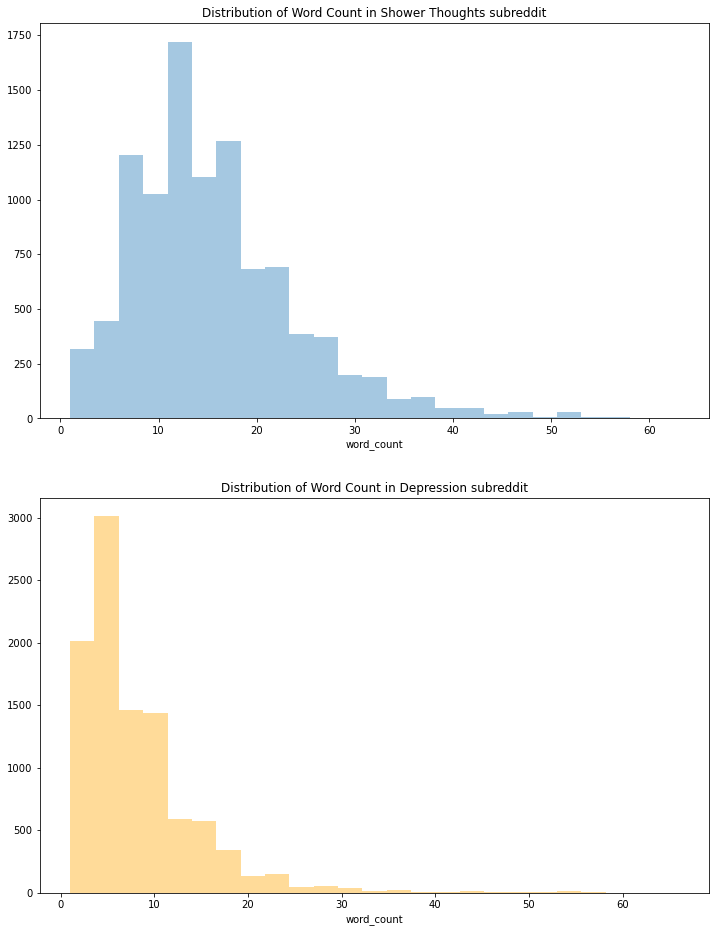

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1)

# height
fig.set_figheight(16)
fig.set_figwidth(12)


sns.distplot(a=shower['word_count'],kde=False,bins=25,ax=ax1)
sns.distplot(a=depression['word_count'],kde=False,bins=25,ax=ax2,color='orange')

ax1.set_title('Distribution of Word Count in Shower Thoughts subreddit')
ax2.set_title('Distribution of Word Count in Depression subreddit');

plt.savefig('imgs/word_dist.png')

<font color = 'orange'> char_count

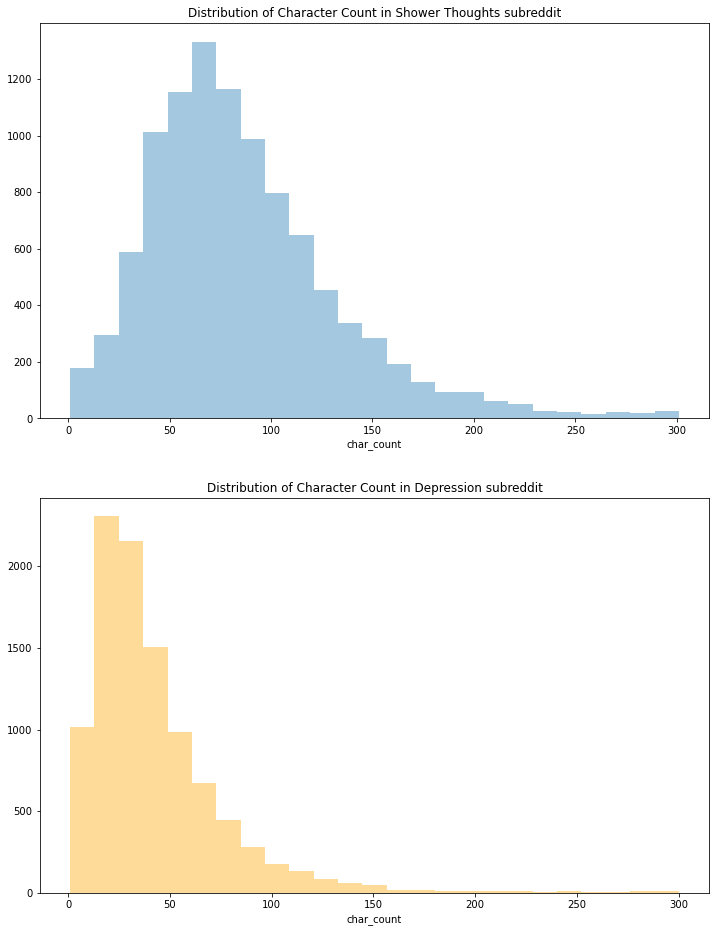

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1)

# height
fig.set_figheight(16)
fig.set_figwidth(12)


sns.distplot(a=shower['char_count'],kde=False,bins=25,ax=ax1)
sns.distplot(a=depression['char_count'],kde=False,bins=25,ax=ax2,color='orange')

ax1.set_title('Distribution of Character Count in Shower Thoughts subreddit')
ax2.set_title('Distribution of Character Count in Depression subreddit');

In the `depression` subreddit, it is more right skewed compared the more "normal bell curve looking" `shower thoughts` subreddit.

# Let's CountVectorize to find more trends

Something I will note ahead of time. I want to create an additional amount of stop words. Reason is to avoid any short hand as well as see if my model can improve accuracy. This list will be carried into my modeling notebook [here]().

In [33]:
add_words = ['depression','shower thoughts'] 
# reason for these words is due to the fact that they are the name of the subreddits
# there could be possible short hands.

In [34]:
# Instantiate
cvec = CountVectorizer()
cvec2 =  CountVectorizer(stop_words='english')

# FIt and Transform
X = cvec.fit_transform(thoughts['title'])
X2 = cvec2.fit_transform(thoughts['title'])

# Store in DataFrame
dummy_thoughts = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())
dummy_thoughts2 = pd.DataFrame(X2.todense(), columns=cvec2.get_feature_names())

In [35]:
dummy_thoughts.head()

,00,000,000001,000gm,001,01,050,06am,09,09380025751,...,𝔫𝔬𝔱,𝔬𝔟𝔰𝔢𝔯𝔳𝔢,𝔬𝔱𝔥𝔢𝔯,𝔯𝔢𝔩𝔞𝔱𝔦𝔳𝔢,𝔱𝔥𝔢,𝔱𝔬,𝔱𝔯𝔞𝔭,𝔲𝔫𝔱𝔦𝔩,𝔴𝔬𝔯𝔡𝔰,𝔶𝔬𝔲
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
dummy_thoughts.shape

(19999, 14676)

# Top 25 words, including stopwords

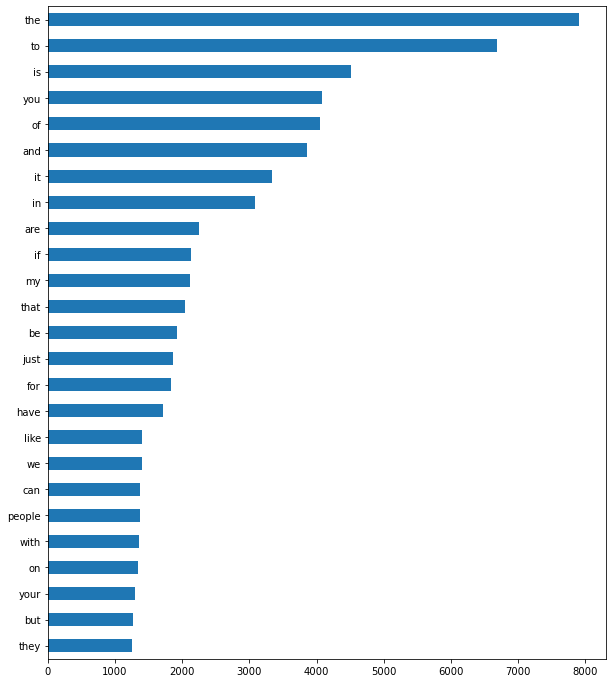

In [37]:
plt.figure(figsize=(10,12))
dummy_thoughts.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0);

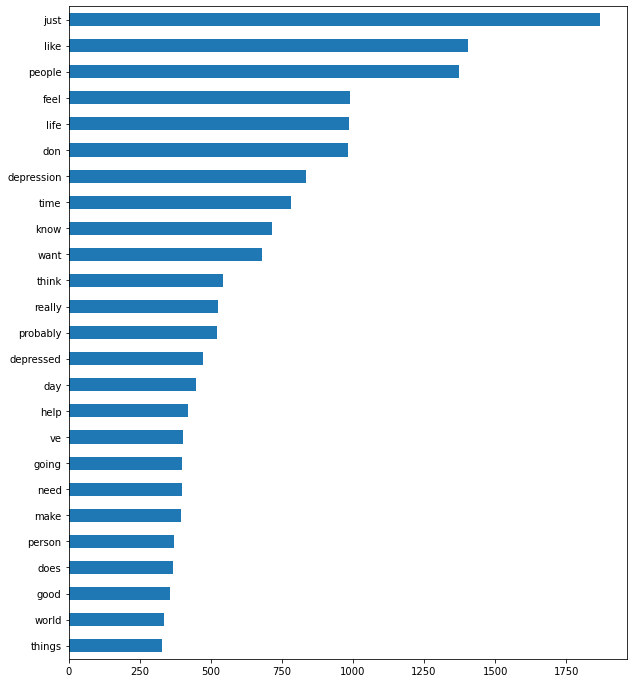

In [38]:
plt.figure(figsize=(10,12))
dummy_thoughts2.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0);

The second bar plot takes note that the word "just" appears very often and that the variations of "depressed" most likely came from the `depression` subreddit.

# Let's also look at the dataframe separated by the two subreddits

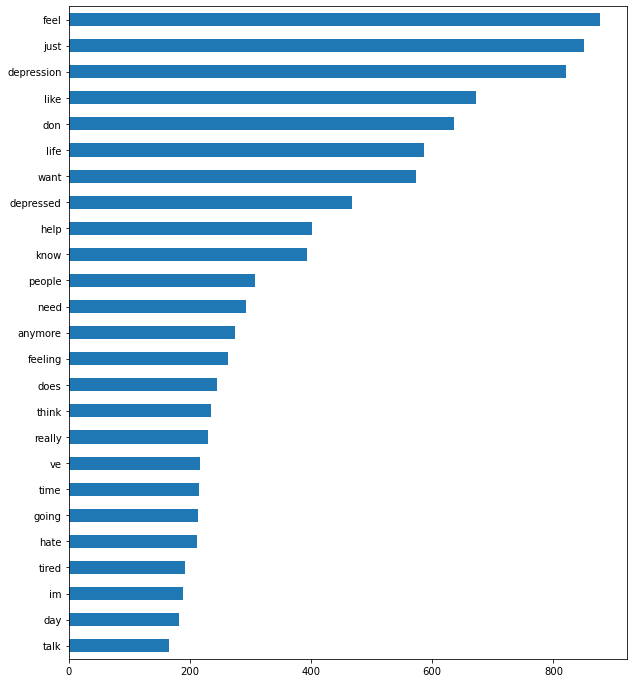

In [39]:
# Instantiate, Fit, Transform, Store in df
cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(depression['title'])
dep_df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())

# Plot
plt.figure(figsize=(10,12))
dep_df.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0);

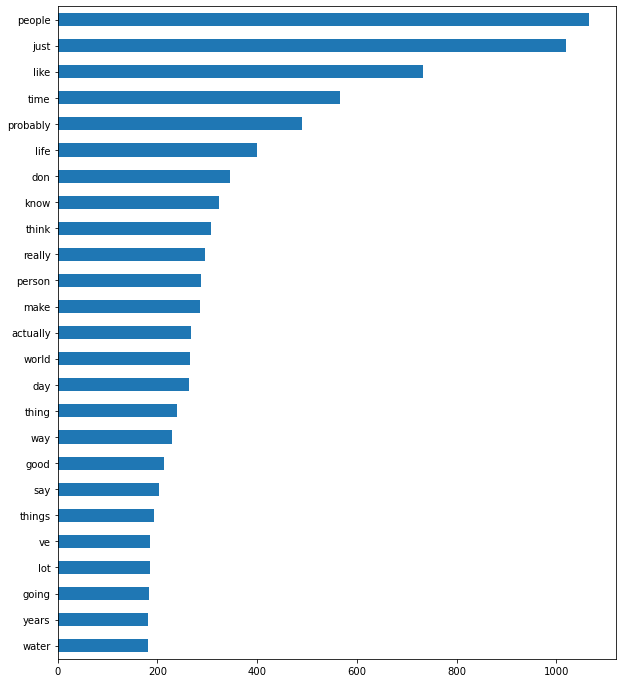

In [40]:
# Instantiate, Fit, Transform, Store in df
cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(shower['title'])
sho_df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())

# Plot
plt.figure(figsize=(10,12))
sho_df.sum().sort_values().tail(25).plot(kind='barh')
plt.xticks(rotation=0);